# Проект "Прогнозирование температуры плавления стали"


**Описание проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

• data_arc_new.csv — данные об электродах;

• data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

• data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

• data_gas_new.csv — данные о продувке сплава газом;

• data_temp_new.csv — результаты измерения температуры;

• data_wire_new.csv — данные о проволочных материалах (объём);

• data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
!pip install shap

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")
%config InlineBackend.figure_format = 'svg'

## Загрузка данных

In [4]:
def check_df(df):
    display(df.head())
    display(df.describe())
    df.info()

### Данные об электродах и результаты измерения температуры

In [5]:
try:
    data_arc = pd.read_csv(r'J:/pyfiles/data/industry/data_arc_new.csv', 
                           parse_dates = ['start_heat_time','end_heat_time'], 
                           index_col = 'key', 
                           header = 0, 
                           names = ['key', 
                                    'start_heat_time',
                                    'end_heat_time', 
                                    'active_power', 
                                    'reactive_power'])
    data_temp = pd.read_csv(r'J:/pyfiles/data/industry/data_temp_new.csv',
                            parse_dates = ['check_time'],
                            index_col = 'key',
                            header = 0, 
                            names = ['key', 'check_time', 'temperature'])
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv', 
                           parse_dates = ['start_heat_time','end_heat_time'], 
                           index_col = 'key', 
                           header = 0, 
                           names = ['key', 
                                    'start_heat_time',
                                    'end_heat_time', 
                                    'active_power', 
                                    'reactive_power'])
    data_temp = pd.read_csv('/datasets/data_temp_new.csv',
                            parse_dates = ['check_time'],
                            index_col = 'key',
                            header = 0, 
                            names = ['key', 'check_time', 'temperature'])

In [6]:
df_list = {
    'data_arc': data_arc,
    'data_temp': data_temp,
}
for name, df in df_list.items():
    display(f"Рассматриваемый датасет: {name}")
    display(df.head())
    display(df.describe())
    display(df.info())
    display(f'Кол-во дупликатов {df.duplicated().sum()}')

'Рассматриваемый датасет: data_arc'

,start_heat_time,end_heat_time,active_power,reactive_power
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,start_heat_time,end_heat_time,active_power,reactive_power
count,14876,14876,14876.000000,14876.000000
mean,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,NaN,NaN,0.258885,5.873485


<class 'pandas.core.frame.DataFrame'>
Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_heat_time  14876 non-null  datetime64[ns]
 1   end_heat_time    14876 non-null  datetime64[ns]
 2   active_power     14876 non-null  float64       
 3   reactive_power   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


None

'Кол-во дупликатов 0'

'Рассматриваемый датасет: data_temp'

,check_time,temperature
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0


,check_time,temperature
count,18092,14665.000000
mean,2019-07-05 13:36:58.791620608,1590.722741
min,2019-05-03 11:02:04,1191.000000
25%,2019-06-04 00:35:01.249999872,1580.000000
50%,2019-07-03 02:11:48,1590.000000
75%,2019-08-07 23:10:05.249999872,1599.000000
max,2019-09-06 17:30:05,1705.000000
std,NaN,20.394381


<class 'pandas.core.frame.DataFrame'>
Index: 18092 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   check_time   18092 non-null  datetime64[ns]
 1   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 424.0 KB


None

'Кол-во дупликатов 0'

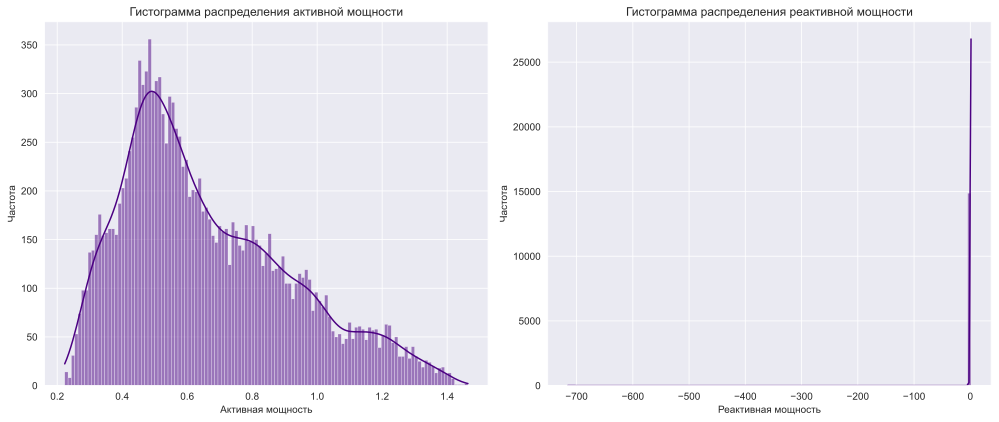

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_arc['active_power'],
             kde=True,
             bins=int(math.sqrt(len(data_arc['active_power']))),
             color='#4B0082')
plt.title("Гистограмма распределения активной мощности")
plt.xlabel('Активная мощность')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(data_arc['reactive_power'],
             kde=True,
             bins=int(math.sqrt(len(data_arc['reactive_power']))),
             color='#4B0082')
plt.title("Гистограмма распределения реактивной мощности")
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

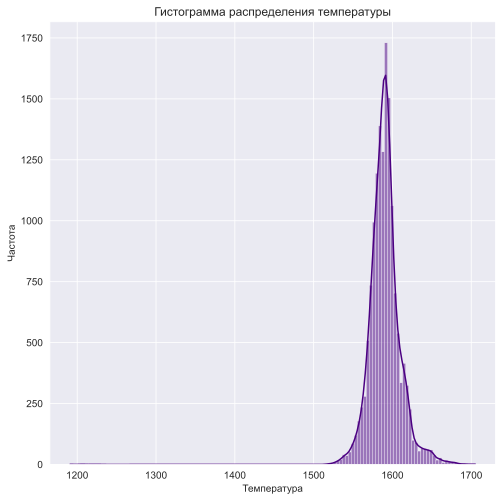

In [8]:
plt.figure(figsize = (8,8))
sns.histplot(data_temp['temperature'],
             kde = True,
             bins = int(math.sqrt(len(data_temp['temperature']))),
             color = '#4B0082')
plt.title(f"Гистограмма распределения температуры")
plt.xlabel('Температура')
plt.ylabel('Частота');

#### Вывод

В датасете *data_arc* представлены 14876 строк данных об электродах и их мощностях, в нем отсутствуют, как пропуски, так и дубликаты, присутствует выброс в столбце реактивной мощности, от которого нужно будет избавиться на этапе предобратобки данных.

В датасете *data_temp* представлены 18092 строки данных замеров температуры распределенных по времени, следовательно здесь имеет место временный ряд, который нужно будет подробно изучить, в нем отсутствуют дубликаты, но присутствуют пропусти в столбце температура.

### Данные о подаче сыпучих материалов

In [9]:
try:
    data_bulk = pd.read_csv(r'J:/pyfiles/data/industry/data_bulk_new.csv', 
                            index_col = 'key',
                            header = 0, 
                            names = ['key', 
                                     'bulk_1',
                                     'bulk_2',
                                     'bulk_3',
                                     'bulk_4',
                                     'bulk_5',
                                     'bulk_6',
                                     'bulk_7',
                                     'bulk_8',
                                     'bulk_9',
                                     'bulk_10',
                                     'bulk_11',
                                     'bulk_12',
                                     'bulk_13',
                                     'bulk_14',
                                     'bulk_15'])
    data_bulk_time = pd.read_csv(r'J:/pyfiles/data/industry/data_bulk_time_new.csv', 
                                 index_col = 'key',
                                 parse_dates = ['bulk_1',
                                                'bulk_2',
                                                'bulk_3',
                                                'bulk_4',
                                                'bulk_5',
                                                'bulk_6',
                                                'bulk_7',
                                                'bulk_8',
                                                'bulk_9',
                                                'bulk_10',
                                                'bulk_11',
                                                'bulk_12',
                                                'bulk_13',
                                                'bulk_14',
                                                'bulk_15'],
                                 header = 0, 
                                 names = ['key', 
                                          'bulk_1',
                                          'bulk_2',
                                          'bulk_3',
                                          'bulk_4',
                                          'bulk_5',
                                          'bulk_6',
                                          'bulk_7',
                                          'bulk_8',
                                          'bulk_9',
                                          'bulk_10',
                                          'bulk_11',
                                          'bulk_12',
                                          'bulk_13',
                                          'bulk_14',
                                          'bulk_15'])
except:
    data_bulk = pd.read_csv(r'/datasets/data_bulk_new.csv', 
                            index_col = 'key',
                            header = 0, 
                            names = ['key', 
                                     'bulk_1',
                                     'bulk_2',
                                     'bulk_3',
                                     'bulk_4',
                                     'bulk_5',
                                     'bulk_6',
                                     'bulk_7',
                                     'bulk_8',
                                     'bulk_9',
                                     'bulk_10',
                                     'bulk_11',
                                     'bulk_12',
                                     'bulk_13',
                                     'bulk_14',
                                     'bulk_15'])
    data_bulk_time = pd.read_csv(r'/datasets/data_bulk_time_new.csv', 
                                 index_col = 'key',
                                 parse_dates = ['bulk_1',
                                                'bulk_2',
                                                'bulk_3',
                                                'bulk_4',
                                                'bulk_5',
                                                'bulk_6',
                                                'bulk_7',
                                                'bulk_8',
                                                'bulk_9',
                                                'bulk_10',
                                                'bulk_11',
                                                'bulk_12',
                                                'bulk_13',
                                                'bulk_14',
                                                'bulk_15'],
                                 header = 0, 
                                 names = ['key', 
                                          'bulk_1',
                                          'bulk_2',
                                          'bulk_3',
                                          'bulk_4',
                                          'bulk_5',
                                          'bulk_6',
                                          'bulk_7',
                                          'bulk_8',
                                          'bulk_9',
                                          'bulk_10',
                                          'bulk_11',
                                          'bulk_12',
                                          'bulk_13',
                                          'bulk_14',
                                          'bulk_15'])

In [10]:
df_list = {
    'data_bulk': data_bulk,
    'data_bulk_time': data_bulk_time,
}
for name, df in df_list.items():
    display(f"Рассматриваемый датасет: {name}")
    display(df.head())
    display(df.describe())
    display(df.info())

'Рассматриваемый датасет: data_bulk'

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   252 non-null    float64
 1   bulk_2   22 non-null     float64
 2   bulk_3   1298 non-null   float64
 3   bulk_4   1014 non-null   float64
 4   bulk_5   77 non-null     float64
 5   bulk_6   576 non-null    float64
 6   bulk_7   25 non-null     float64
 7   bulk_8   1 non-null      float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


None

'Рассматриваемый датасет: data_bulk_time'

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   bulk_1   252 non-null    datetime64[ns]
 1   bulk_2   22 non-null     datetime64[ns]
 2   bulk_3   1298 non-null   datetime64[ns]
 3   bulk_4   1014 non-null   datetime64[ns]
 4   bulk_5   77 non-null     datetime64[ns]
 5   bulk_6   576 non-null    datetime64[ns]
 6   bulk_7   25 non-null     datetime64[ns]
 7   bulk_8   1 non-null      datetime64[ns]
 8   bulk_9   19 non-null     datetime64[ns]
 9   bulk_10  176 non-null    datetime64[ns]
 10  bulk_11  177 non-null    datetime64[ns]
 11  bulk_12  2450 non-null   datetime64[ns]
 12  bulk_13  18 non-null     datetime64[ns]
 13  bulk_14  2806 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


None

#### Вывод

В датасетах *data_bulk* и *data_bulk_time* представлены данные о подаче сыпучих материалов и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.

### Данные о проволочных материалах

In [11]:
try:
    data_wire = pd.read_csv(r'J:/pyfiles/data/industry/data_wire_new.csv', 
                            index_col='key',
                            header = 0, 
                            names = ['key', 
                                     'wire_1',
                                     'wire_2',
                                     'wire_3',
                                     'wire_4',
                                     'wire_5',
                                     'wire_6',
                                     'wire_7',
                                     'wire_8',
                                     'wire_9'])
    data_wire_time = pd.read_csv(r'J:/pyfiles/data/industry/data_wire_time_new.csv', 
                                 index_col='key', 
                                 parse_dates=['wire_1',
                                              'wire_2',
                                              'wire_3',
                                              'wire_4',
                                              'wire_5',
                                              'wire_6',
                                              'wire_7',
                                              'wire_8',
                                              'wire_9'],
                                 header = 0, 
                                 names = ['key', 
                                          'wire_1',
                                          'wire_2',
                                          'wire_3',
                                          'wire_4',
                                          'wire_5',
                                          'wire_6',
                                          'wire_7',
                                          'wire_8',
                                          'wire_9'])
except:
    data_wire = pd.read_csv(r'/datasets/data_wire_new.csv', 
                            index_col='key',
                            header = 0, 
                            names = ['key', 
                                     'wire_1',
                                     'wire_2',
                                     'wire_3',
                                     'wire_4',
                                     'wire_5',
                                     'wire_6',
                                     'wire_7',
                                     'wire_8',
                                     'wire_9'])
    data_wire_time = pd.read_csv(r'/datasets/data_wire_time_new.csv', 
                                 index_col='key', 
                                 parse_dates=['wire_1',
                                              'wire_2',
                                              'wire_3',
                                              'wire_4',
                                              'wire_5',
                                              'wire_6',
                                              'wire_7',
                                              'wire_8',
                                              'wire_9'],
                                 header = 0, 
                                 names = ['key', 
                                          'wire_1',
                                          'wire_2',
                                          'wire_3',
                                          'wire_4',
                                          'wire_5',
                                          'wire_6',
                                          'wire_7',
                                          'wire_8',
                                          'wire_9'])

In [12]:
df_list = {
    'data_wire': data_wire,
    'data_wire_time': data_wire_time,
}
for name, df in df_list.items():
    display(f"Рассматриваемый датасет: {name}")
    display(df.head())
    display(df.describe())
    display(df.info())

'Рассматриваемый датасет: data_wire'

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3055 non-null   float64
 1   wire_2  1079 non-null   float64
 2   wire_3  63 non-null     float64
 3   wire_4  14 non-null     float64
 4   wire_5  1 non-null      float64
 5   wire_6  73 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


None

'Рассматриваемый датасет: data_wire_time'

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055,1079,63,14,1,73,11,19,29
mean,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wire_1  3055 non-null   datetime64[ns]
 1   wire_2  1079 non-null   datetime64[ns]
 2   wire_3  63 non-null     datetime64[ns]
 3   wire_4  14 non-null     datetime64[ns]
 4   wire_5  1 non-null      datetime64[ns]
 5   wire_6  73 non-null     datetime64[ns]
 6   wire_7  11 non-null     datetime64[ns]
 7   wire_8  19 non-null     datetime64[ns]
 8   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


None

#### Вывод

В датасетах *data_wire* и *data_wire_time* представлены данные о проволочных материалах и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.

### Данные о газе

In [13]:
try:
    data_gas = pd.read_csv(r'J:/pyfiles/data/industry/data_gas_new.csv', 
                           index_col='key',
                           header = 0, 
                           names = ['key', 'gas'])
except:
    data_gas = pd.read_csv(r'/datasets/data_gas_new.csv', 
                           index_col='key',
                           header = 0, 
                           names = ['key', 'gas'])

In [14]:
df_list = {
    'data_gas': data_gas
}
for name, df in df_list.items():
    display(f"Рассматриваемый датасет: {name}")
    display(df.head())
    display(df.describe())
    display(df.info())
    display(f'Кол-во дупликатов {df.duplicated().sum()}')

'Рассматриваемый датасет: data_gas'

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


None

'Кол-во дупликатов 0'

#### Вывод

В датасете *data_gas* представлены данные об объеме подаваемого газа в за партию, пропусков и дубликатов нет.

### Вывод

Мной било загружено и просмотренно 7 датасетов, изменен тип записи столбцов к snake case:

В датасете *data_arc* представлены 14876 строк данных об электродах и их мощностях, в нем отсутствуют, как пропуски, так и дубликаты, присутствует выброс в столбце реактивной мощности, от которого нужно будет избавиться на этапе предобратобки данных.

В датасете *data_temp* представлены 18092 строки данных замеров температуры распределенных по времени, следовательно здесь имеет место временный ряд, который нужно будет подробно изучить, в нем отсутствуют дубликаты, но присутствуют пропусти в столбце температура.

В датасетах *data_bulk* и *data_bulk_time* представлены данные о подаче сыпучих материалов и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.

В датасетах *data_wire* и *data_wire_time* представлены данные о проволочных материалах и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.

В датасете *data_gas* представлены данные об объеме подаваемого газа в за партию, пропусков и дубликатов нет.

## Исследовательский анализ и предобработка данных

### Исследовательский анализ и предобработка ***data_arc***

Первым делом нужно избавиться от явного выброса

In [15]:
data_arc = data_arc[(data_arc['active_power'] >=0) & (data_arc['reactive_power'] >= 0)]

In [16]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14875 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_heat_time  14875 non-null  datetime64[ns]
 1   end_heat_time    14875 non-null  datetime64[ns]
 2   active_power     14875 non-null  float64       
 3   reactive_power   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


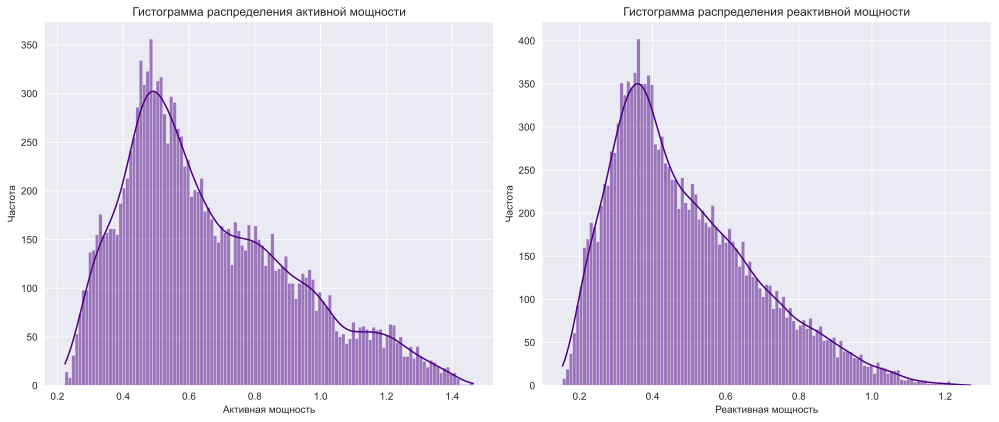

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_arc['active_power'],
             kde=True,
             bins=int(math.sqrt(len(data_arc['active_power']))),
             color='#4B0082')
plt.title("Гистограмма распределения активной мощности")
plt.xlabel('Активная мощность')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(data_arc['reactive_power'],
             kde=True,
             bins=int(math.sqrt(len(data_arc['reactive_power']))),
             color='#4B0082')
plt.title("Гистограмма распределения реактивной мощности")
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

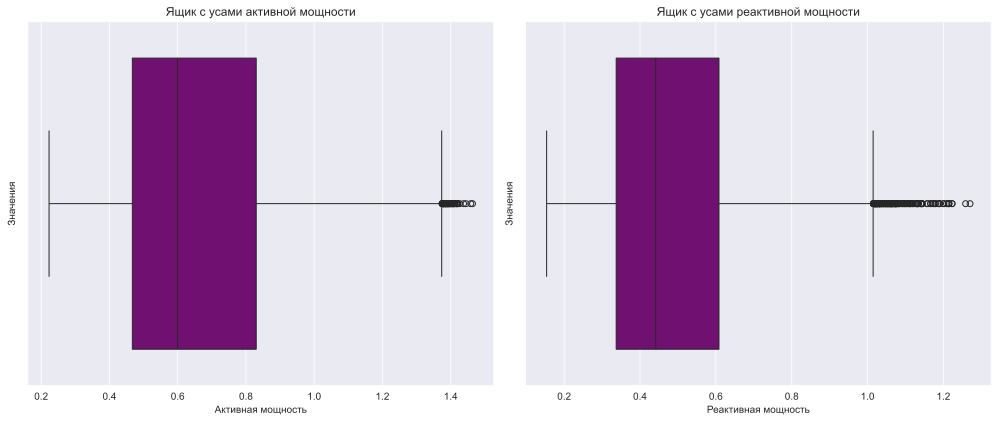

In [18]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

sns.boxplot(x=data_arc['active_power'], color='purple')
plt.title("Ящик с усами активной мощности")
plt.xlabel('Активная мощность')
plt.ylabel('Значения')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_arc['reactive_power'], color='purple')
plt.title("Ящик с усами реактивной мощности")
plt.xlabel('Реактивная мощность')
plt.ylabel('Значения')
plt.tight_layout()
plt.show()

In [19]:
data_arc_filtered = data_arc.copy()

In [20]:
data_arc_filtered['heat_time'] = (data_arc_filtered['end_heat_time'] - data_arc_filtered['start_heat_time']).dt.total_seconds()

In [21]:
data_arc_filtered['full_power'] = np.sqrt(data_arc_filtered['active_power']**2 + data_arc_filtered['reactive_power']**2)

In [22]:
agr_arc_filtered = data_arc_filtered.pivot_table(index='key',
                                                 values=['active_power',
                                                         'reactive_power',
                                                         'heat_time',
                                                         'full_power'], aggfunc='sum')

In [23]:
agr_arc_filtered['num_turns_on'] = data_arc_filtered.pivot_table(index='key',
                                           values='reactive_power',
                                           aggfunc='count').rename(columns={"reactive_power": 'num_turns_on'})['num_turns_on']

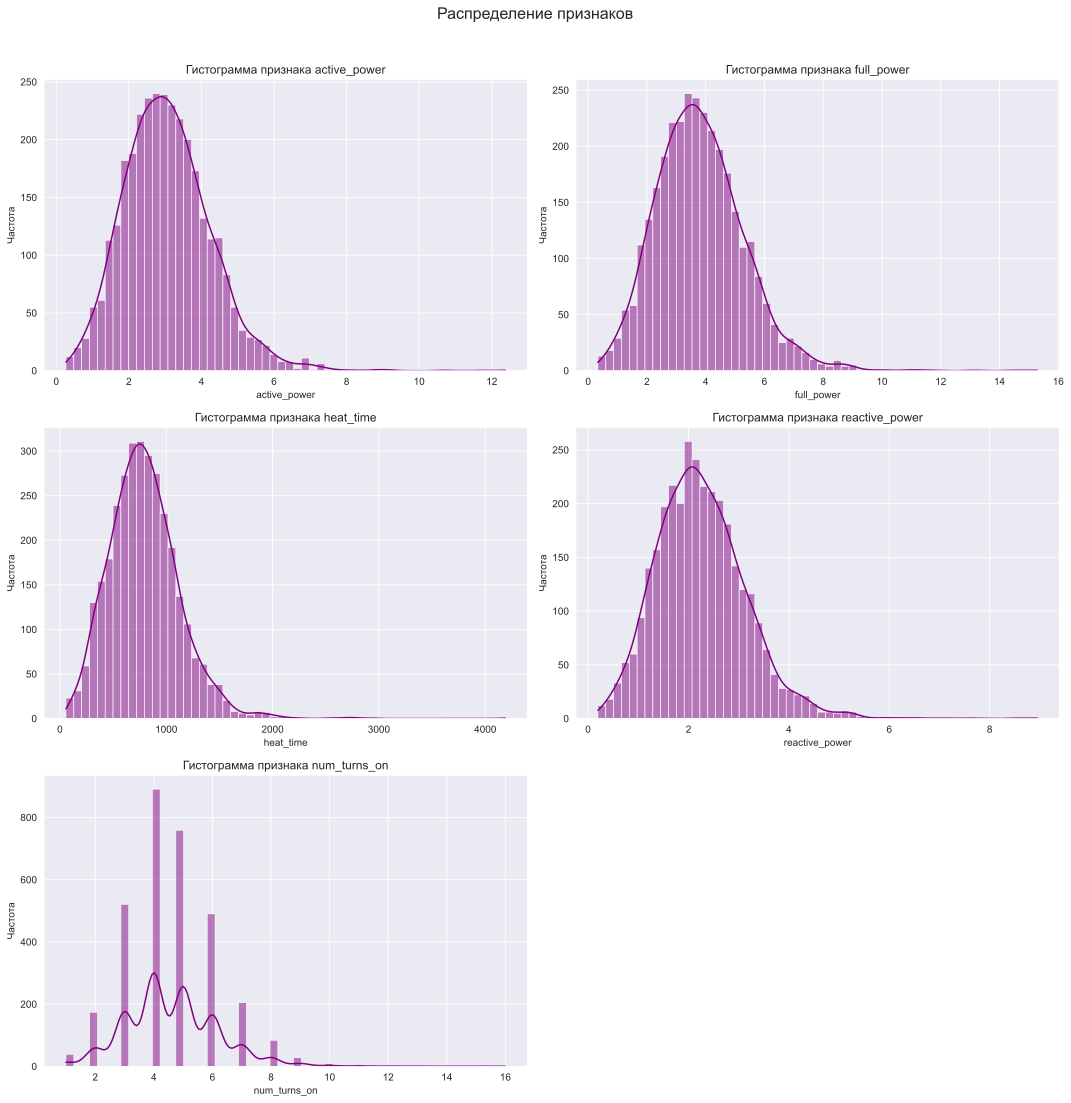

In [24]:
num_cols = agr_arc_filtered.select_dtypes(include='number').columns

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.suptitle("Распределение признаков", y=1.02, fontsize=16)

axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(agr_arc_filtered[col],
                 kde=True,
                 bins=int(math.sqrt(len(agr_arc_filtered[col]))),
                 color='purple',
                 ax=ax)
    ax.set_title(f"Гистограмма признака {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Частота")

if len(num_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [25]:
display(agr_arc_filtered.head())
display(agr_arc_filtered.describe())
agr_arc_filtered.info()

,active_power,full_power,heat_time,reactive_power,num_turns_on
key,,,,,
1,3.036730,3.718736,1098.0,2.142821,5
2,2.139408,2.588349,811.0,1.453357,4
3,4.063641,5.019223,655.0,2.937457,5
4,2.706489,3.400038,741.0,2.056992,4
5,2.252950,2.816980,869.0,1.687991,4


,active_power,full_power,heat_time,reactive_power,num_turns_on
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,3.067329,3.810779,794.545115,2.254462,4.628189
std,1.208697,1.502804,332.491076,0.894743,1.608866
min,0.267676,0.331897,57.000000,0.196228,1.000000
25%,2.235394,2.775306,571.000000,1.630658,4.000000
50%,2.984581,3.694219,770.000000,2.176833,4.000000
75%,3.775472,4.696915,983.000000,2.788330,6.000000
max,12.375636,15.288271,4189.000000,8.949049,16.000000


<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active_power    3214 non-null   float64
 1   full_power      3214 non-null   float64
 2   heat_time       3214 non-null   float64
 3   reactive_power  3214 non-null   float64
 4   num_turns_on    3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


#### Вывод

В датасете ***data_arc*** былы удалены аномалии, а так же были вычислены полная мощность, кол-во включений электричества и время работы в секундах.

Можно заметить, что в среднем за партию вырабатывается 3.6, максимально потребленное кол-во энергии за партию 15.2.

### Исследовательский анализ и предобработка ***data_temp***

In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18092 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   check_time   18092 non-null  datetime64[ns]
 1   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 424.0 KB


In [27]:
agr_temp = data_temp.groupby('key').apply(lambda x: x.sort_values('check_time').iloc[-1]).rename(columns={'temperature':'last_temp'})

In [28]:
agr_temp = agr_temp.dropna()

In [29]:
agr_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   check_time  2477 non-null   datetime64[ns]
 1   last_temp   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.1 KB


In [30]:
agr_temp['first_temp'] = (data_temp.pivot_table(index='key', values='temperature', aggfunc='first')
            .rename(columns={'temperature':'first_temp'}))

In [31]:
agr_temp['mean_temp'] = data_temp.pivot_table(index='key', values='temperature', aggfunc='mean')
agr_temp['mean_temp'] = round(agr_temp['mean_temp'], 2)
agr_temp.head()

,check_time,last_temp,first_temp,mean_temp
key,,,,
1,2019-05-03 11:30:38,1613.0,1571.0,1602.17
2,2019-05-03 11:55:09,1602.0,1581.0,1590.60
3,2019-05-03 12:35:57,1599.0,1596.0,1598.17
4,2019-05-03 12:59:47,1625.0,1601.0,1616.80
5,2019-05-03 13:36:39,1602.0,1576.0,1589.00


In [32]:
agr_temp = agr_temp.drop(columns = 'check_time')

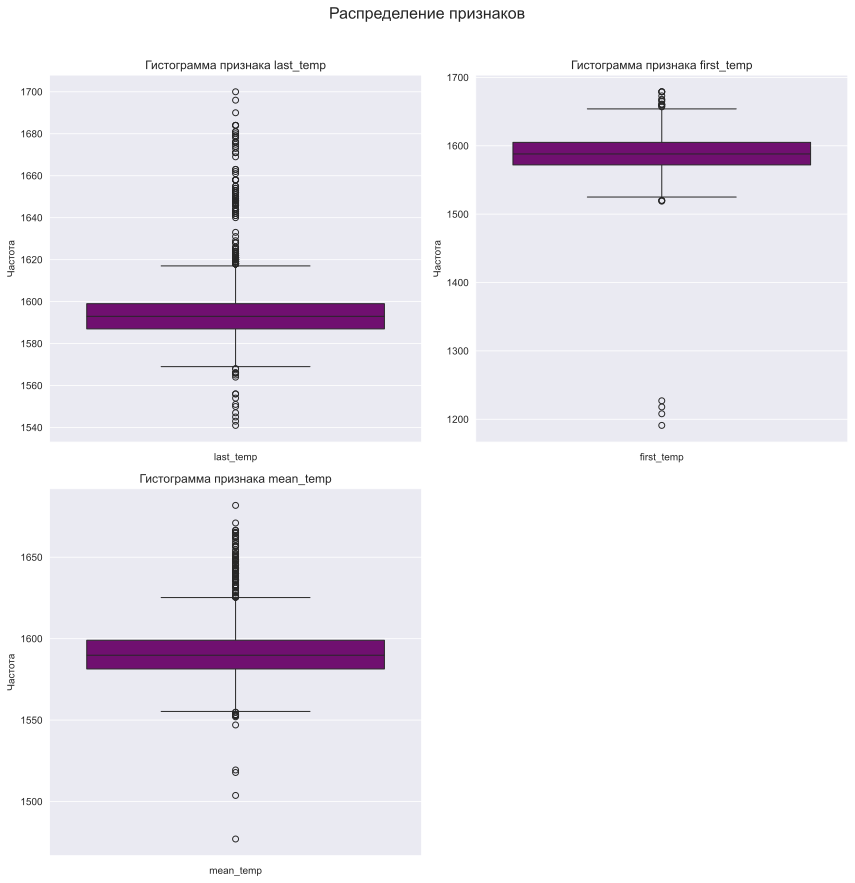

In [33]:
num_cols = agr_temp.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.suptitle("Распределение признаков", y=1.02, fontsize=16)

axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(agr_temp[col],
                 color='purple',
                 ax=ax)
    ax.set_title(f"Гистограмма признака {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Частота")

if len(num_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [34]:
agr_temp = agr_temp[(agr_temp['first_temp']>= 1300) & (agr_temp['last_temp']>1300)]

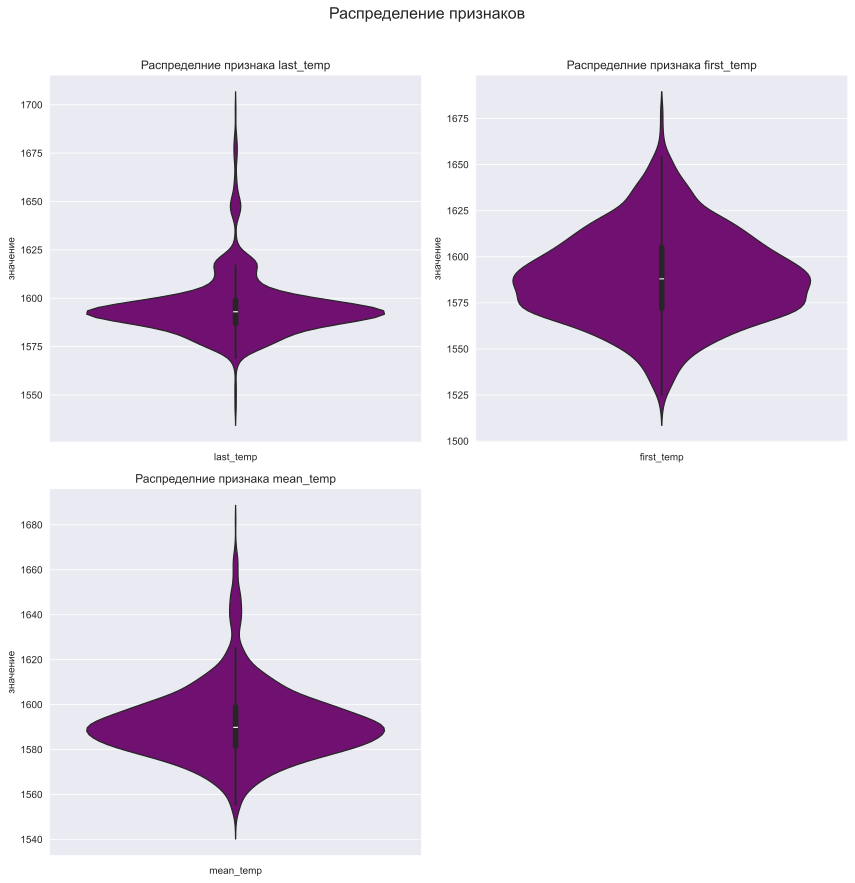

In [35]:
num_cols = agr_temp.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.suptitle("Распределение признаков", y=1.02, fontsize=16)

axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.violinplot(agr_temp[col],
                 color='purple',
                 ax=ax)
    ax.set_title(f"Распределние признака {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("значение")

if len(num_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Вывод

В датасете ***data_temp*** былы удалены явные аномалии, а так же были найдены первая, последняя и средняя температура за каждую партию, а так же можно зпметить, что последняя температура имеет более стабильное распределение, а первая меньший разброс.

### Исследовательский анализ и предобработка ***data_bulk*** и ***data_bulk_time***

In [36]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [37]:
data_bulk['bulk_sum'] = data_bulk.sum(axis = 1)
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


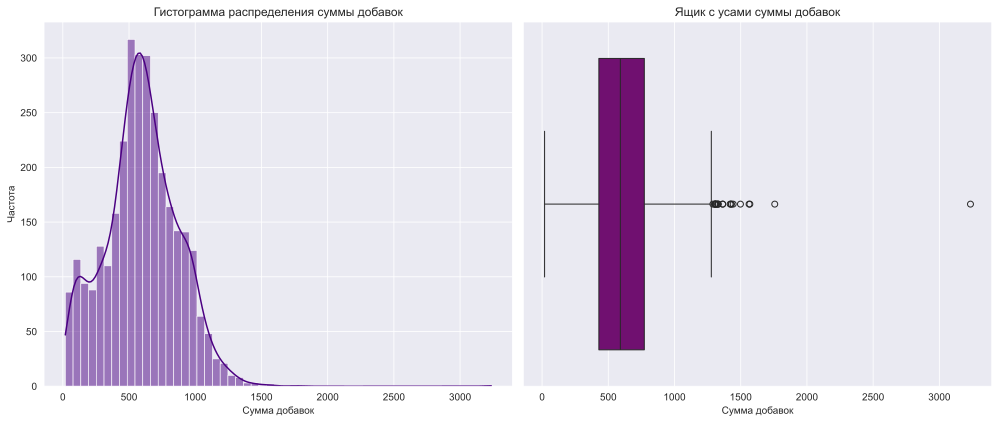

In [38]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_bulk['bulk_sum'],
             kde=True,
             bins=int(math.sqrt(len(data_bulk['bulk_sum']))),
             color='#4B0082')
plt.title("Гистограмма распределения суммы добавок")
plt.xlabel('Сумма добавок')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_bulk['bulk_sum'], color='purple')
plt.title("Ящик с усами суммы добавок")
plt.xlabel('Сумма добавок')
plt.tight_layout()
plt.show()

In [39]:
data_bulk = data_bulk[data_bulk['bulk_sum'] < 2000]

In [40]:
data_bulk[data_bulk['bulk_sum'] == 0]

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
key,,,,,,,,,,,,,,,,


In [41]:
data_bulk.describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,3.102302,1.779731,47.223146,33.822890,2.634591,21.899297,2.312660,0.015665,0.463555,4.686061,4.346867,203.422315,1.042199,152.552110,115.356138,594.659527
std,11.416852,21.221246,74.245598,56.041797,20.921430,55.500074,31.123161,0.876118,6.155377,20.160372,22.703077,148.558184,14.116497,80.642435,84.477031,272.543510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,429.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,591.000000
75%,0.000000,0.000000,79.250000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,772.000000
max,118.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.000000,305.000000,601.000000,405.000000,1757.000000


In [42]:
data_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


#### Вывод

В датасете *data_bulk* пропуски были заменены на 0 и посчитана сумма материалов за партию, далее обработана явная аномалия, средний объем подавемых сыпучих материалов равен 594, при этом есть партии в которые подавлось 19 и 1757. Датасет *data_bulk_time* не несет никакой важной информации для решения поставленной задачи.

### Исследовательский анализ и предобработка *data_wire* и *data_wire_time*

In [43]:
data_wire = data_wire.fillna(0)

In [44]:
data_wire['wire_sum'] = data_wire.sum(axis = 1)
data_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
key,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


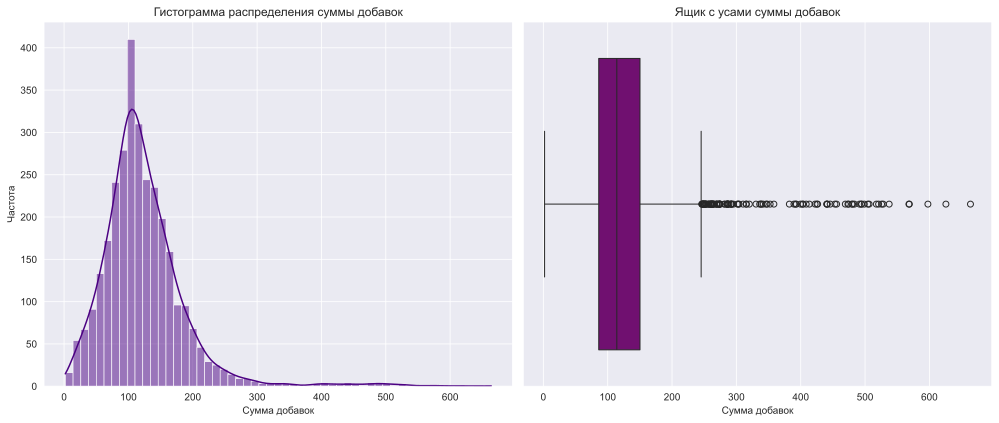

In [45]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_wire['wire_sum'],
             kde=True,
             bins=int(math.sqrt(len(data_wire['wire_sum']))),
             color='#4B0082')
plt.title("Гистограмма распределения суммы добавок")
plt.xlabel('Сумма добавок')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_wire['wire_sum'], color='purple')
plt.title("Ящик с усами суммы добавок")
plt.xlabel('Сумма добавок')
plt.tight_layout()
plt.show()

In [46]:
data_wire = data_wire[data_wire['wire_sum'] < 550]

In [47]:
data_wire.describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
count,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000
mean,99.914513,17.546162,3.385541,0.261443,0.004919,1.139545,0.035900,0.331235,0.322015,122.941273
std,42.750900,33.147775,27.735032,4.297341,0.272837,8.965274,0.774818,4.396227,3.809975,63.205343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.918800
25%,70.199997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.086263
50%,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.157681
75%,125.295304,23.153520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.132833
max,330.314424,282.780152,309.381073,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604,537.487236


In [48]:
data_wire_time.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


#### Вывод

В датасете *data_wire* пропуски были заменены на 0 и посчитана сумма материалов за партию, далее обработана явная аномалия, средний объем подавемых проводов равен 123, при этом есть партии в которые подавлось 1 и 537. Датасет *data_wire_time* не несет никакой важной информации для решения поставленной задачи.

### Исследовательский анализ и предобработка *data_gas*

In [49]:
data_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


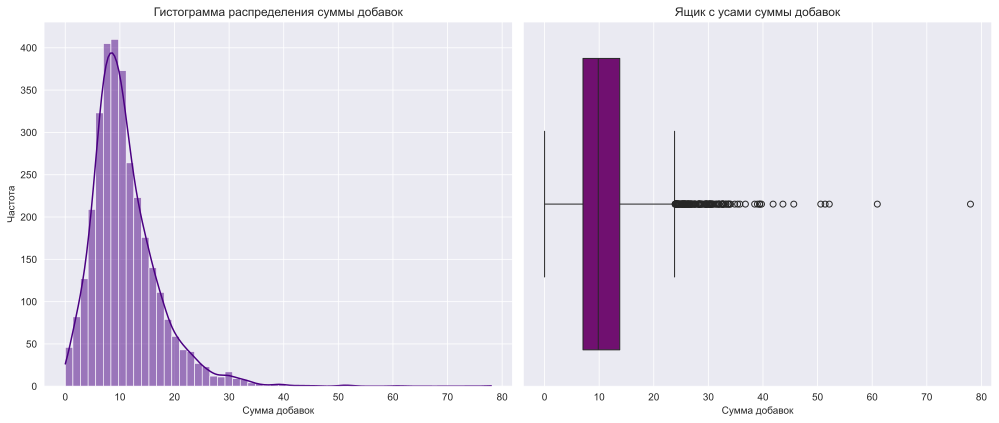

In [50]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_gas['gas'],
             kde=True,
             bins=int(math.sqrt(len(data_gas['gas']))),
             color='#4B0082')
plt.title("Гистограмма распределения суммы добавок")
plt.xlabel('Сумма добавок')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_gas['gas'], color='purple')
plt.title("Ящик с усами суммы добавок")
plt.xlabel('Сумма добавок')
plt.tight_layout()
plt.show()

In [51]:
data_gas = data_gas[data_gas['gas'] < 60]

In [52]:
data_gas.describe()

,gas
count,3237.000000
mean,10.965940
std,6.046293
min,0.008399
25%,7.042268
50%,9.828795
75%,13.767550
max,52.142373


#### Вывод

В датасете *data_gas* были обработаны явные аномалии, средний объем газа 11, минимальный близок к 0, а максимальный 52.

### Вывод

При исследовательском анализе и предобработке данных было сделано и замечено следующее

В датасете ***data_arc*** былы удалены аномалии, а так же были вычислены полная мощность, кол-во включений электричества и время работы в секундах, среднее потребление кол-ва энергии за партию 3.6, максимально потребленное кол-во энергии за партию 15.2.

В датасете ***data_temp*** былы удалены явные аномалии, а так же были найдены первая, последняя и средняя температура за каждую партию, а так же можно зпметить, что последняя температура имеет более стабильное распределение, а первая меньший разброс.

В датасете *data_bulk* пропуски были заменены на 0 и посчитана сумма материалов за партию, после чего от всех остальных данных было решено избавиться за их несостоятельность в обунии модели, далее обработана явная аномалия, средний объем подавемых сыпучих материалов равен 594, при этом есть партии в которые подавлось 19 и 1757. 

Датасет *data_bulk_time* не несет никакой важной информации для решения поставленной задачи.

В датасете *data_wire* пропуски были заменены на 0 и посчитана сумма материалов за партию, после чего от всех остальных данных было решено избавиться за их несостоятельность в обунии модели, далее обработана явная аномалия, средний объем подавемых проводов равен 123, при этом есть партии в которые подавлось 1 и 537. 

Датасет *data_wire_time* не несет никакой важной информации для решения поставленной задачи.

В датасете *data_gas* были обработаны явные аномалии, средний объем газа 11, минимальный близок к 0, а максимальный 52.

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [53]:
full_df = agr_temp.join([agr_arc_filtered, data_bulk, data_wire, data_gas], how = 'inner')

In [54]:
display(full_df.head())
full_df.shape

,last_temp,first_temp,mean_temp,active_power,full_power,heat_time,reactive_power,num_turns_on,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,gas
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1602.17,3.036730,3.718736,1098.0,2.142821,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
2,1602.0,1581.0,1590.60,2.139408,2.588349,811.0,1.453357,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
3,1599.0,1596.0,1598.17,4.063641,5.019223,655.0,2.937457,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
4,1625.0,1601.0,1616.80,2.706489,3.400038,741.0,2.056992,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
5,1602.0,1576.0,1589.00,2.252950,2.816980,869.0,1.687991,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692


(2321, 35)

In [55]:
corr = full_df.corr(method = 'spearman').abs().sort_values(by = 'last_temp', ascending=False)
corr_df = pd.DataFrame(corr['last_temp']).fillna(0)
corr_df

,last_temp
last_temp,1.000000
mean_temp,0.665576
first_temp,0.309248
wire_1,0.300865
bulk_6,0.264254
bulk_12,0.239357
wire_2,0.237016
heat_time,0.235722
bulk_4,0.234874
bulk_15,0.227545


In [56]:
full_df = full_df.drop(columns=corr_df[corr_df['last_temp'] <= 0.1].index.to_list())

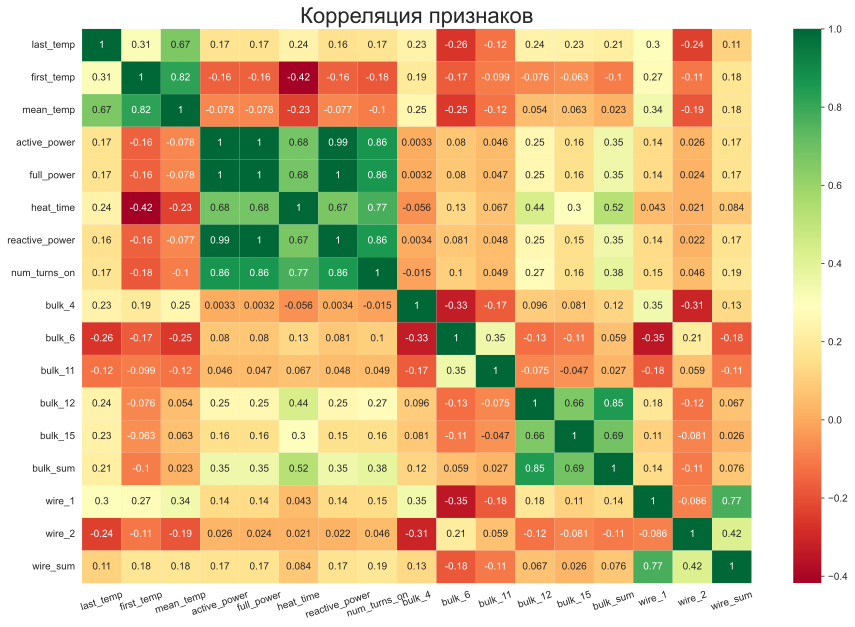

In [57]:
plt.figure(figsize=(15,10))
fig = sns.heatmap(full_df.corr(method='spearman'), cmap='RdYlGn', annot=True)
plt.title('Корреляция признаков', fontsize=22)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

In [58]:
cols_to_drop = ['mean_temp', 'active_power', 'reactive_power']

In [59]:
full_df = full_df.drop(columns=cols_to_drop)

### Вывод

При исследовательском анализе и предобработке данных объединённого датафрейма я объединил все рабочие датафреймы в один, далее проверил корреляцию призноков и оставил те, у которых с целевым признаком больше 0.1, и так же убрал повторяющие друг друга признаки.

## Подготовка данных и обучение моделей машинного обучения

In [60]:
y = full_df['last_temp']
X = full_df.drop(columns=['last_temp'], axis=1)

RANDOM_STATE = 120824

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= .25,
                                                    random_state=RANDOM_STATE)

print(f'X_train.shape: {X_train.shape}, y_train_shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_train_shape: {y_test.shape}')

X_train.shape: (1740, 13), y_train_shape: (1740,)
X_test.shape: (581, 13), y_train_shape: (581,)


In [61]:
num_cols = X.columns
num_pipe = Pipeline(
    steps=[
        ('num_scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [('num', num_pipe, num_cols)],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
]
)

param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_leaf': [5, 10, 15],
        'model__min_samples_split': [2, 5, 10],
        'model__max_features': [None, 'auto', 'sqrt', 'log2'],
        'model__max_leaf_nodes': [None, 10, 20, 50]
    },

    {
        'model':[KNeighborsRegressor()],
        'model__n_neighbors': range(4,20, 2)
    },
    
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'model__learning_rate': [0.001, 0.01, 0.1, 1],
        'model__iterations': [200, 400, 800],
        'model__depth': [4, 6, 8, 10],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__bagging_temperature': [0.2, 0.5, 1.0]
    },
    
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-100)],
        'model__n_estimators': [200, 400, 800, 1000],
        'model__learning_rate': [0.001, 0.01, 0.1, 1],
        'model__max_depth': [-1, 5, 10, 15],
        'model__num_leaves': [31, 50, 100],
        'model__min_child_samples': [20, 50, 100]
    }
]

In [62]:
%%time
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           n_jobs=-1,
                           cv=5,
                           scoring='neg_mean_absolute_error')

grid_search.fit(X_train,y_train)

CPU times: total: 2min 21s
Wall time: 2h 51min 55s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['first_temp', 'full_power', 'heat_time', 'num_turns_on', 'bulk_4',
       'bulk_6', 'bulk_11', 'bulk_12', 'bulk_15', 'bulk_sum', 'wire_1',
       'wire_2', 'wire_sum'],
      dtype='object'))])),
                                       ('model'...
                          'model__l2_leaf_reg': [1, 3, 5, 7],
                          'model__learning_rate': [0.001, 0.01, 0.1, 1]},
                         {'model': [LGBMRegressor(random_state=120824,
                                                  verbose=-100)],
                          'model__learning_rate': [0.001, 0.01, 0.1, 1],
                          'model__max_depth': [-1, 5, 10, 15],
                          'model__min_child_samples': [20, 50, 100],
                          'model__n_estimators': [200, 400, 800, 1000],
                          'model__num_leaves': [31, 50, 100]}],
             scoring='neg_mean_absolute_error')

In [68]:
print(f'Лучшая модель: {grid_search.best_estimator_}')
print(f'Лучшая метрика на кросс-валидации:{grid_search.best_score_}')

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['first_temp', 'full_power', 'heat_time', 'num_turns_on', 'bulk_4',
       'bulk_6', 'bulk_11', 'bulk_12', 'bulk_15', 'bulk_sum', 'wire_1',
       'wire_2', 'wire_sum'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x0000029D75127260>)])
Лучшая метрика на кросс-валидации:-6.073581047764478


In [71]:
grid_search.best_params_

{'model': <catboost.core.CatBoostRegressor at 0x29d75af9b50>,
 'model__bagging_temperature': 0.2,
 'model__depth': 6,
 'model__iterations': 200,
 'model__l2_leaf_reg': 5,
 'model__learning_rate': 0.1}

### Вывод

Мною были обучены 4 модели МО: Древо решений, Ближаших соседей, catboost и LGBM. Лучшую метрику, а имено nmae -6 показала модель catboost c параметрами: bagging_temperature = 0.2, depth = 6, iterations = 200, l2_leaf_reg = 5, learning_rate = 0.1.

## Выбор лучшей модели

### Предсказание на тестовых данных

In [64]:
best_model = grid_search.best_estimator_
y_predict = best_model.predict(X_test)
print(f'MAE на тестовой выборке: {mean_absolute_error(y_predict, y_test)}')

MAE на тестовой выборке: 6.619331733091163


### Интерпретация признаков модели

In [65]:
final_model = best_model.steps[-1][1]
X_train_prep = num_pipe.fit_transform(X_train)
X_test_prep = num_pipe.transform(X_test)

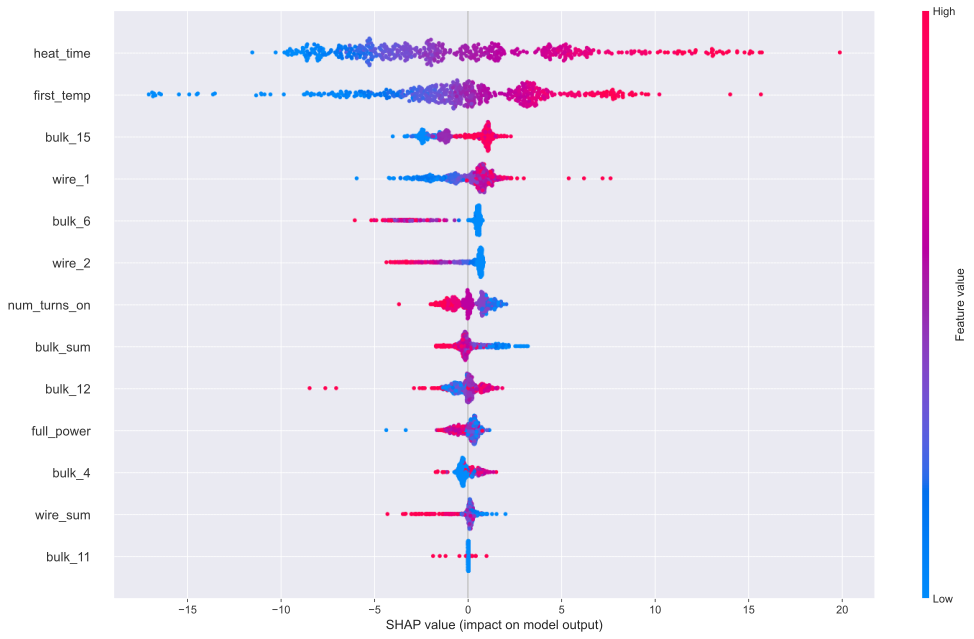

In [67]:
exp = shap.TreeExplainer(final_model, X_test_prep, feature_names=X_test.columns)
values = exp(X_test_prep)

shap.initjs()
shap.summary_plot(values, X_test_prep, plot_type="dot",
                  feature_names=X_test.columns, show=True, plot_size=(15,9))

### Вывод

После предсказания тестовой выборки выяснилось, что MAE равен 6.62, вполне приемлемы результат означающий, что модель в среднем ошидается на 6-7 градусов. Исходя из графика выше, становится ясно, что самыe важныe признак - это температура сплава в начале, а именно это означает, что, чем выше начальная температура в ковше, тем выше конечная температура и наоборот, а так же время нагрева, чем дольше, тем выше температура.

### Общий вывод и рекомендации

Основной задачей данного проекта было уменьшение затрат производства на электроэнергии, для чего нужно было создать модель МО предсказывающую температуру сплава.

Для решения данной задачи я произвел слудующие действия.

Мной било загружено и просмотренно 7 датасетов, изменен тип записи столбцов к snake case:
В датасете *data_arc* представлены 14876 строк данных об электродах и их мощностях, в нем отсутствуют, как пропуски, так и дубликаты, присутствует выброс в столбце реактивной мощности, от которого нужно будет избавиться на этапе предобратобки данных.
В датасете *data_temp* представлены 18092 строки данных замеров температуры распределенных по времени, следовательно здесь имеет место временный ряд, который нужно будет подробно изучить, в нем отсутствуют дубликаты, но присутствуют пропусти в столбце температура.
В датасетах *data_bulk* и *data_bulk_time* представлены данные о подаче сыпучих материалов и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.
В датасетах *data_wire* и *data_wire_time* представлены данные о проволочных материалах и времени их подачи соответственно. В датасетах присутствуют пропуски, которые скорее всего связаны с логикой предприятия, на котором не ведется подсчет времени если материалы не добавляются ибо кол-во пропусков идентично.
В датасете *data_gas* представлены данные об объеме подаваемого газа в за партию, пропусков и дубликатов нет.

При исследовательском анализе и предобработке данных было сделано и замечено следующее
В датасете ***data_arc*** былы удалены аномалии, а так же были вычислены полная мощность, кол-во включений электричества и время работы в секундах, среднее потребление кол-ва энергии за партию 3.6, максимально потребленное кол-во энергии за партию 15.2.
В датасете ***data_temp*** былы удалены явные аномалии, а так же были найдены первая, последняя и средняя температура за каждую партию, а так же можно зпметить, что последняя температура имеет более стабильное распределение, а первая меньший разброс.
В датасете *data_bulk* пропуски были заменены на 0 и посчитана сумма материалов за партию, после чего от всех остальных данных было решено избавиться за их несостоятельность в обунии модели, далее обработана явная аномалия, средний объем подавемых сыпучих материалов равен 594, при этом есть партии в которые подавлось 19 и 1757. 
Датасет *data_bulk_time* не несет никакой важной информации для решения поставленной задачи.
В датасете *data_wire* пропуски были заменены на 0 и посчитана сумма материалов за партию, после чего от всех остальных данных было решено избавиться за их несостоятельность в обунии модели, далее обработана явная аномалия, средний объем подавемых проводов равен 123, при этом есть партии в которые подавлось 1 и 537. 
Датасет *data_wire_time* не несет никакой важной информации для решения поставленной задачи.
В датасете *data_gas* были обработаны явные аномалии, средний объем газа 11, минимальный близок к 0, а максимальный 52.

При исследовательском анализе и предобработке данных объединённого датафрейма я объединил все рабочие датафреймы в один, далее проверил корреляцию призноков и оставил те, у которых с целевым признаком больше 0.1, и так же убрал повторяющие друг друга признаки.

Мною были обучены 4 модели МО: Древо решений, Ближаших соседей, catboost и LGBM. Лучшую метрику, а имено nmae -6 показала модель catboost c параметрами: bagging_temperature = 0.2, depth = 6, iterations = 200, l2_leaf_reg = 5, learning_rate = 0.1.

После предсказания тестовой выборки выяснилось, что MAE равен 6.62, вполне приемлемы результат означающий, что модель в среднем ошидается на 6-7 градусов. Исходя из графика выше, становится ясно, что самыe важныe признак - это температура сплава в начале, а именно это означает, что, чем выше начальная температура в ковше, тем выше конечная температура и наоборот, а так же время нагрева, чем дольше, тем выше температура.

Дам слудующие рекомендации. Собирать больше данных о температуре и электродах, прийти к единому стандарту производства нужного сплава, просчитав все издержки на нагрев простичать нужное кол-во рассходных материалов.